# Groupby 

files needed = ('Most-Recent-Cohorts-Institution.csv')

We often want to know how groups differ. Do workers with econ degrees make more than workers with history degrees? Do men live longer than women? Does it matter how much education you have? 

Pandas provides the `groupby()` method to ease computing statistics by group ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)). This kind of method shows up in many data-oriented computing languages and packages. The idea is summed up as 

> split-apply-combine

Here is the canonical [illustration](https://www.oreilly.com/library/view/learning-pandas/9781783985128/ch09s02.html). The big idea is to 
1. **Split** the data up into groups. The groups are defined by *key* variables.
2. **Apply** some method or function to each group: mean, std, max, etc. This returns a smaller bit of data, often just one number.
3. **Combine** the results of the 'apply' from each group into a new data structure.
  
  
Apply-split-combine is an incredibly powerful feature of pandas. We will cover the basics here. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# this tells pandas to print out 3 decimal places when we print a DataFrame
pd.set_option('display.precision', 3)       


## College Scorecard
Let's take this opportunity to learn about a new dataset: [The College Scorecard](https://collegescorecard.ed.gov/data/). The data are compiled by the Dept. of Education to help students evaluate higher education institutions. The data are very well documented and include such juicy variables as: prices, after program debt levels, earnings, completion rates, and information about student outcomes by family income and other demographic variables. 

We will be working off of the 'institution-level' data file.

\[There is an [api](https://collegescorecard.ed.gov/data/documentation/), too, but we would all have to sign up for a key.\]



The data set is large. There are thousands of variables. I am creating a dict that holds the variable name in the data set and the name I will use in my DataFrame. This will come in handy...

How did I figure out the variable names and definitions? I read [the documentation](https://collegescorecard.ed.gov/data/documentation/).

In [2]:
variables = {'CONTROL':'ownership', 'INSTNM':'name', 
             'STABBR':'state', 'PREDDEG':'type', 
             'SATVRMID':'sat_read_med', 'SATMTMID':'sat_math_med', 'SATWRMID':'sat_write_med', 
             'PCIP52':'sh_bus', 'PCIP11':'sh_cs', 'PCIP14':'sh_eng', 'PCIP26':'sh_bio', 
             'PCIP45':'sh_ss', 'PCIP51':'sh_health', 'PCIP09':'sh_com',
             'MD_EARN_WNE_P10':'earn_10', 'GRAD_DEBT_MDN_SUPP':'debt_at_grad'}

In [3]:
variables.keys()

dict_keys(['CONTROL', 'INSTNM', 'STABBR', 'PREDDEG', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'PCIP52', 'PCIP11', 'PCIP14', 'PCIP26', 'PCIP45', 'PCIP51', 'PCIP09', 'MD_EARN_WNE_P10', 'GRAD_DEBT_MDN_SUPP'])

In [4]:
colscd = pd.read_csv('Most-Recent-Cohorts-Institution.csv', na_values=['PrivacySuppressed', 'NULL'], usecols=variables.keys())


We are loading a new data set. Let's do our checks. 

Here, I'm using the `.info()` method of DataFrame. It gives me the shape of the DataFrame and the dtypes. 

In [5]:
colscd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6681 entries, 0 to 6680
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INSTNM              6681 non-null   object 
 1   STABBR              6681 non-null   object 
 2   PREDDEG             6681 non-null   int64  
 3   CONTROL             6681 non-null   int64  
 4   SATVRMID            1085 non-null   float64
 5   SATMTMID            1085 non-null   float64
 6   SATWRMID            705 non-null    float64
 7   PCIP09              5835 non-null   float64
 8   PCIP11              5835 non-null   float64
 9   PCIP14              5835 non-null   float64
 10  PCIP26              5835 non-null   float64
 11  PCIP45              5835 non-null   float64
 12  PCIP51              5835 non-null   float64
 13  PCIP52              5835 non-null   float64
 14  MD_EARN_WNE_P10     5025 non-null   float64
 15  GRAD_DEBT_MDN_SUPP  4892 non-null   float64
dtypes: flo

In [6]:
display(colscd.head(2))
display(colscd.tail(2))

,INSTNM,STABBR,PREDDEG,CONTROL,SATVRMID,SATMTMID,SATWRMID,PCIP09,PCIP11,PCIP14,PCIP26,PCIP45,PCIP51,PCIP52,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
0,Alabama A & M University,AL,3,1,475.0,455.0,414.0,0.000,0.034,0.157,0.128,0.031,0.000,0.162,36339.0,31000.0
1,University of Alabama at Birmingham,AL,3,1,614.0,595.0,NaN,0.032,0.026,0.055,0.097,0.031,0.237,0.199,46990.0,22250.0


,INSTNM,STABBR,PREDDEG,CONTROL,SATVRMID,SATMTMID,SATWRMID,PCIP09,PCIP11,PCIP14,PCIP26,PCIP45,PCIP51,PCIP52,MD_EARN_WNE_P10,GRAD_DEBT_MDN_SUPP
6679,Pennsylvania State University-Penn State Harri...,PA,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6680,Pennsylvania State University-Penn State Brand...,PA,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's clean this up a bit. 

Let's rename the variables to something easier to understand and keep just a few variables that look interesting. 

In [7]:
colscd = colscd.rename(columns = variables)
colscd.head(3)

,name,state,type,ownership,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
0,Alabama A & M University,AL,3,1,475.0,455.0,414.0,0.000,0.034,0.157,0.128,0.031,0.000,0.162,36339.0,31000.0
1,University of Alabama at Birmingham,AL,3,1,614.0,595.0,NaN,0.032,0.026,0.055,0.097,0.031,0.237,0.199,46990.0,22250.0
2,Amridge University,AL,2,2,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.522,37895.0,31417.0


The ownership and type variables are coded as integers. I would rather they were easy to understand. We could use statements like

```python 
colscd.loc[colscd['type']==1, 'type'] = 'cert'
```
for each change we want to make, but that would get tedious. Instead, we will use the pandas method `.replace()`. We pass the `.replace()` method a dictionary in which the keys are the objects we want to replace and the values are what we want to replace them with. 

Let's take a look.

In [8]:
type_codes = {0:'na', 1:'cert', 2:'assoc', 3:'bach', 4:'grad_only'}
colscd['type'] = colscd['type'].replace(type_codes)

own_codes = {1:'Public', 2:'Private nonprofit', 3:'Private profit'}
colscd['ownership'] = colscd['ownership'].replace(own_codes)
colscd.head()

,name,state,type,ownership,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
0,Alabama A & M University,AL,bach,Public,475.0,455.0,414.0,0.000,0.034,0.157,0.128,0.031,0.000,0.162,36339.0,31000.0
1,University of Alabama at Birmingham,AL,bach,Public,614.0,595.0,NaN,0.032,0.026,0.055,0.097,0.031,0.237,0.199,46990.0,22250.0
2,Amridge University,AL,assoc,Private nonprofit,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.522,37895.0,31417.0
3,University of Alabama in Huntsville,AL,bach,Public,645.0,655.0,NaN,0.015,0.067,0.285,0.059,0.012,0.163,0.173,54361.0,21450.0
4,Alabama State University,AL,bach,Public,485.0,462.0,NaN,0.096,0.057,0.005,0.059,0.016,0.111,0.114,32084.0,31000.0


Set the index to the university name. 
How does the UW look?

In [9]:
colscd.set_index('name', inplace=True)
colscd.loc['University of Wisconsin-Madison']

state                 WI
type                bach
ownership         Public
sat_read_med       650.0
sat_math_med       710.0
sat_write_med      640.0
sh_com             0.065
sh_cs              0.058
sh_eng             0.094
sh_bio             0.101
sh_ss              0.089
sh_health          0.073
sh_bus             0.147
earn_10          65213.0
debt_at_grad     20500.0
Name: University of Wisconsin-Madison, dtype: object

We are a public university that predominantly gives out bachelor degrees. The largest major is business, then biology and engineering. Median earnings 10 years after graduating is 65k and median debt at graduation is 20k.

The data are in good shape. Let's explore `.groupby()`. 

## 1. Split: groupby( )
We pass `.groupby()` a 'key' which tells the method which variable to, well, group by. We will group by state. This is the **split** step.

What is `colscd_grouped`?

In [10]:
colscd_grouped = colscd.groupby('state')
print(type(colscd_grouped))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


A DataFrameGroupBy object. This is basically a DataFrame + the grouping information. 

What does it look like? A DataFrameGroupBy is an iterable object. It returns subsets of the original DataFrame by group. In our case, the groups are defined by state. 

The `.get_group()` returns a group. 

In [11]:
colscd_grouped.get_group('WI').sort_index()

#colscd[colscd['state']=='WI'].sort_index()
#colscd_grouped.get_group('AK').sort_index()

# Notice 'name' is not actually a unique identifier for the level of observation

,state,type,ownership,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
Academy of Beauty Professionals,WI,cert,Private profit,NaN,NaN,NaN,0.000,0.000,0.0,0.000,0.000,0.000,0.000,24071.0,7917.0
Academy of Beauty Professionals,WI,cert,Private profit,NaN,NaN,NaN,0.000,0.000,0.0,0.000,0.000,0.000,0.000,24071.0,7917.0
Academy of Beauty Professionals,WI,cert,Private profit,NaN,NaN,NaN,0.000,0.000,0.0,0.000,0.000,0.000,0.000,24071.0,7917.0
Advanced College of Cosmetology,WI,cert,Private profit,NaN,NaN,NaN,0.000,0.000,0.0,0.000,0.000,0.000,0.000,NaN,NaN
Alverno College,WI,bach,Private nonprofit,NaN,NaN,498.0,0.027,0.003,0.0,0.037,0.024,0.324,0.115,47595.0,27000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Waukesha County Technical College,WI,cert,Public,NaN,NaN,NaN,0.000,0.069,0.0,0.000,0.000,0.433,0.130,38952.0,12211.0
Western Technical College,WI,cert,Public,NaN,NaN,NaN,0.005,0.042,0.0,0.000,0.000,0.495,0.153,40372.0,11500.0
Wisconsin Lutheran College,WI,bach,Private nonprofit,540.0,550.0,NaN,0.059,0.036,0.0,0.073,0.014,0.105,0.356,47930.0,26000.0


...and there is every degree-granting institution in Wisconsin from [Academy of Beauty Professionals](https://www.academyofbeautyprofessionals.com/) to the [Wright Graduate University for the Realization of Human Potential](http://www.wrightgrad.edu/).

## 2. + 3. Apply and combine
A major use of groupby is to perform some kind of aggregation. This is the **apply** and **combine** step. Let's take the grouped data and compute some means. 

In [12]:
all_means = colscd_grouped.mean()  # apply the mean operator to the grouped data

print(type(all_means))             # what do we get back?

<class 'pandas.core.frame.DataFrame'>


In [13]:
# Ah, a DataFrame. We know what to do with that. 
all_means.head(10)

,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
state,,,,,,,,,,,,
AK,585.000,575.000,482.500,0.002,0.021,0.015,0.010,0.010,0.179,0.180,42270.714,18277.400
AL,550.895,544.579,498.000,0.013,0.021,0.016,0.026,0.013,0.216,0.118,36591.563,20249.212
AR,548.154,540.615,464.200,0.007,0.016,0.004,0.015,0.009,0.195,0.090,31120.347,14847.957
AS,NaN,NaN,NaN,0.000,0.000,0.067,0.000,0.033,0.144,0.139,27265.000,NaN
AZ,577.833,565.833,505.000,0.006,0.021,0.007,0.005,0.009,0.240,0.061,36405.658,12363.085
CA,588.032,589.286,570.540,0.012,0.024,0.007,0.012,0.029,0.255,0.084,42634.264,14462.200
CO,567.857,563.929,570.000,0.022,0.024,0.021,0.015,0.019,0.206,0.093,39542.412,15761.932
CT,590.786,587.000,532.083,0.018,0.013,0.027,0.022,0.040,0.225,0.095,48662.018,15499.277
DC,626.600,621.600,605.000,0.026,0.084,0.018,0.023,0.086,0.188,0.212,49081.471,21456.737


When we used `.mean()` on the grouped data, it **applied** the mean method to each group, which creates one number per group (for each column). It then **combined** the means into a DataFrame, one number per group per column. Nice.  

Notice that the categorical data (name, state, type) have been dropped. `.mean()` doesn't know what to do with string data.

Here we can see the result of `pd.set_option('display.precision', 3)`. The output is limited to 3 decimal places. 

## 1. + 2. + 3. Split-apply-combine

Computing the grouped data first helped us understand what was happening, but we can do the whole split-apply-combine in one step. One simple line of code.

In [14]:
all_means = colscd.groupby('state').mean()
all_means.head(10)

,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
state,,,,,,,,,,,,
AK,585.000,575.000,482.500,0.002,0.021,0.015,0.010,0.010,0.179,0.180,42270.714,18277.400
AL,550.895,544.579,498.000,0.013,0.021,0.016,0.026,0.013,0.216,0.118,36591.563,20249.212
AR,548.154,540.615,464.200,0.007,0.016,0.004,0.015,0.009,0.195,0.090,31120.347,14847.957
AS,NaN,NaN,NaN,0.000,0.000,0.067,0.000,0.033,0.144,0.139,27265.000,NaN
AZ,577.833,565.833,505.000,0.006,0.021,0.007,0.005,0.009,0.240,0.061,36405.658,12363.085
CA,588.032,589.286,570.540,0.012,0.024,0.007,0.012,0.029,0.255,0.084,42634.264,14462.200
CO,567.857,563.929,570.000,0.022,0.024,0.021,0.015,0.019,0.206,0.093,39542.412,15761.932
CT,590.786,587.000,532.083,0.018,0.013,0.027,0.022,0.040,0.225,0.095,48662.018,15499.277
DC,626.600,621.600,605.000,0.026,0.084,0.018,0.023,0.086,0.188,0.212,49081.471,21456.737


### Aggregation methods

Some common aggregation methods include: `.mean()`, `.sum()`, `.std()`, `.describe()`, `.min()`, `.max()`, but there are many more. Any function that returns a scalar will work. 

### groupby( ) on a subset of columns
We may not care about all the columns in our datset for a particular groupby. We can subset our DataFrame as usual and compute a groupby. This saves computing statistics we do not want. For a large data set, this can save time.

Let's focus on the median SAT scores. We will group by the 'ownership' variable.

In [15]:
# Grab the cols we want from the df before using the groupby. Remember to keep the grouping variable, too.
sat_medians_1 = colscd[['sat_read_med', 'sat_math_med', 'sat_write_med', 'ownership']].groupby('ownership').median()
sat_medians_1

,sat_read_med,sat_math_med,sat_write_med
ownership,,,
Private nonprofit,560.0,547.0,508.0
Private profit,563.5,568.5,475.0
Public,550.0,545.0,495.0


## Practice

1. Create a dataset with only the public institutions from `colscd` DataFrame. Name it `pub`. 

The public institutions are the ones with `ownership` equal to 'Public'. 

In [16]:
pub = colscd[colscd['ownership'] == 'Public']
pub

,state,type,ownership,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
Alabama A & M University,AL,bach,Public,475.0,455.0,414.0,0.000,0.034,0.157,0.128,0.031,0.000,0.162,36339.0,31000.0
University of Alabama at Birmingham,AL,bach,Public,614.0,595.0,NaN,0.032,0.026,0.055,0.097,0.031,0.237,0.199,46990.0,22250.0
University of Alabama in Huntsville,AL,bach,Public,645.0,655.0,NaN,0.015,0.067,0.285,0.059,0.012,0.163,0.173,54361.0,21450.0
Alabama State University,AL,bach,Public,485.0,462.0,NaN,0.096,0.057,0.005,0.059,0.016,0.111,0.114,32084.0,31000.0
The University of Alabama,AL,bach,Public,600.0,600.0,540.0,0.093,0.014,0.131,0.038,0.041,0.092,0.292,52751.0,23072.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pennsylvania State University-Penn State Wilkes-Barre,PA,na,Public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pennsylvania State University-Penn State York,PA,na,Public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pennsylvania State University-Penn State Great Valley,PA,na,Public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `.quantile()` method ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html)) computes quantiles from the data. (e.g., `.quantile(0.5)` computes the median, or the 50th quantile)

2. Let's look at a measure of the earnings variation for different institution types:

    a. Compute the 75th quantile for 'earn_10' for each 'type'. Name the new DataFrame 'q75'.  
    b. Compute the 50th quantile for 'earn_10' for each 'type'. Name the new DataFrame 'q50'.    
    c. Compute the 25th quantile for 'earn_10' for each 'type'. Name the new DataFrame 'q25'.
    
You should have three new DataFrames, each containing the one of the quantile statistics. 

In [17]:
q75 = pub[['earn_10', 'type']].groupby('type').quantile(0.75)
q50 = pub[['earn_10', 'type']].groupby('type').quantile(0.5)
q25 = pub[['earn_10', 'type']].groupby('type').quantile(0.25)
q25

,earn_10
type,
assoc,33034.50
bach,42102.00
cert,29887.50
grad_only,39152.75
na,34393.00


2d. For each type, compute the difference between the 75 percentile and the 25 percentile and divide it by the median. 

This is sometimes called the *quartile-based coefficient of variation*. It is a measure of the variability of a variable. It is less sensitive to outliers than the coefficient of variation, which is the standard deviation divided by the mean. 

In [18]:
qcv = (q75 - q25) / q50
qcv

,earn_10
type,
assoc,0.184
bach,0.276
cert,0.254
grad_only,0.488
na,0.190


Wow, a lot of dispersion in the grad_only group. I wonder if that is from professional schools. Understanding the variation in income from different school types could be an interesting project. Let's practice some more. 



3. How do reading and writing scores correlate?

    a. Compute the median SAT reading and writing scores by **state**. 


In [19]:
pub_sats = pub[['sat_read_med', 'sat_write_med', 'state']].groupby('state').median()
pub_sats

,sat_read_med,sat_write_med
state,,
AK,585.0,510.0
AL,553.5,514.0
AR,535.0,450.0
AS,NaN,NaN
AZ,602.5,NaN
CA,550.0,570.0
CO,550.0,605.0
CT,550.0,505.0
DC,NaN,NaN


3b. Create a scatter plot with the median reading score on the x axis and writing score on the y axis.  

If you finished early try:
1. Adding the 45-degree line to the plot. 

In [20]:
import seaborn as sns

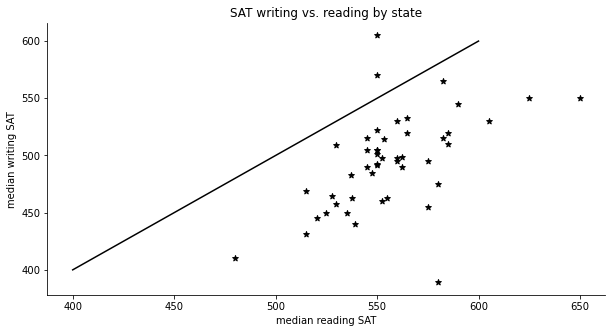

In [21]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax.scatter(pub_sats['sat_read_med'], pub_sats['sat_write_med'],          # scatter plot of nhe vs. gdp
        color='black', marker='*'                   # set the color to black
       )  
ax.plot([400,600], [400,600], color='black')

ax.set_ylabel('median writing SAT')
ax.set_xlabel('median reading SAT')
ax.set_title('SAT writing vs. reading by state')
sns.despine(ax=ax)

plt.show()

### Several statistics at once
Once we have grouped our data, we have been hitting it with methods to compute statistics: `mean()`, `count()`,...

We now introduced the `.agg()` method, which lets us compute several moments at once&mdash;you can even pass it a user-defined function. 

In [22]:
# This is the same as groupby('type').count()
# Note that count doesn't drop the columns that are strings.  
colscd[['earn_10', 'type']].groupby('type').agg('count')
#colscd[['earn_10', 'type']].groupby('type').count()

,earn_10
type,
assoc,977
bach,1811
cert,1838
grad_only,24
na,375


In [23]:
# But agg() lets us compute many stats at once
colscd[['earn_10', 'sat_read_med', 'type']].groupby('type')\
.agg(['count', 'mean', 'median', 'std', 'max'])

earn_10                                          sat_read_med  \
            count       mean   median        std       max        count   
type                                                                      
assoc         977  37069.129  36011.0   9288.002  105693.0           20   
bach         1811  50305.060  47834.0  14723.972  132969.0         1060   
cert         1838  29673.084  27736.5   9801.022   87731.0            5   
grad_only      24  56196.292  52835.0  19159.779   97371.0            0   
na            375  39440.003  38868.0  10931.704   93291.0            0   

                                           
              mean median      std    max  
type                                       
assoc      525.750  515.0   62.393  700.0  
bach       565.911  555.0   63.162  760.0  
cert       525.600  508.0  115.149  700.0  
grad_only      NaN    NaN      NaN    NaN  
na             NaN    NaN      NaN    NaN

Now we have a multiIndex on the columns.

We can use `.agg()` to pass a user-defined function, too. We will work on that in the practice problems. 

### groupby( ) with many keys
Can we group by several keys? You know we can. Let's compute the medians this time.

In [24]:
sat_medians = colscd.groupby(['ownership','type']).median()
sat_medians

sat_read_med  sat_math_med  sat_write_med  \
ownership         type                                                   
Private nonprofit assoc             550.0         516.5          455.0   
                  bach              560.0         549.0          510.0   
                  cert              508.0         491.0          492.5   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   
Private profit    assoc             529.0         532.0            NaN   
                  bach              598.0         605.0          475.0   
                  cert                NaN           NaN            NaN   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   
Public            assoc             510.0         483.0          415.0   
                  bach              550.0         545.0          495.0   
                  cert                NaN           NaN          391.0   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   

                             sh_com  sh_cs  sh_eng  sh_bio  sh_ss  sh_health  \
ownership         type                                                         
Private nonprofit assoc       0.000  0.000   0.000   0.000  0.000      0.058   
                  bach        0.011  0.008   0.000   0.041  0.012      0.033   
                  cert        0.000  0.000   0.000   0.000  0.000      0.581   
                  grad_only   0.000  0.000   0.000   0.000  0.000      0.000   
                  na            NaN    NaN     NaN     NaN    NaN        NaN   
Private profit    assoc       0.000  0.000   0.000   0.000  0.000      0.552   
                  bach        0.000  0.011   0.000   0.000  0.000      0.016   
                  cert        0.000  0.000   0.000   0.000  0.000      0.000   
                  grad_only   0.000  0.000   0.000   0.000  0.000      0.000   
                  na            NaN    NaN     NaN     NaN    NaN        NaN   
Public            assoc       0.000  0.026   0.000   0.000  0.000      0.179   
                  bach        0.035  0.032   0.007   0.049  0.045      0.096   
                  cert        0.000  0.013   0.000   0.000  0.000      0.318   
                  grad_only     NaN    NaN     NaN     NaN    NaN        NaN   
                  na            NaN    NaN     NaN     NaN    NaN        NaN   

                             sh_bus  earn_10  debt_at_grad  
ownership         type                                      
Private nonprofit assoc       0.000  36284.0       16790.0  
                  bach        0.152  48210.0       25000.0  
                  cert        0.000  29463.0       12000.0  
                  grad_only   0.000  52835.0       20750.0  
                  na            NaN  43125.0       25425.0  
Private profit    assoc       0.000  34601.0       16063.0  
                  bach        0.147  43590.0       28308.0  
                  cert        0.000  25028.0        9500.0  
                  grad_only   0.000  67040.5       29349.0  
                  na            NaN  36822.0       20000.0  
Public            assoc       0.096  36177.0       10500.0  
                  bach        0.167  48272.0       21175.0  
                  cert        0.032  33758.0        9500.0  
                  grad_only     NaN  50661.5       26999.0  
                  na            NaN  37321.0       11264.0

Now we have a MultiIndexed DataFrame with the summary statistics, this time, the median. 

The three ownership types all have institutions that predominately offer bachelors degrees. How do the median SAT scores compare across public and private institutions? 

Let's grab that set of statistics, a quick practice with multiIndex. 

In [25]:
bach_sat_med = sat_medians.xs('bach', level='type')         # xs() indexes data from a MultiIndex
bach_sat_med

,sat_read_med,sat_math_med,sat_write_med,sh_com,sh_cs,sh_eng,sh_bio,sh_ss,sh_health,sh_bus,earn_10,debt_at_grad
ownership,,,,,,,,,,,,
Private nonprofit,560.0,549.0,510.0,0.011,0.008,0.000,0.041,0.012,0.033,0.152,48210.0,25000.0
Private profit,598.0,605.0,475.0,0.000,0.011,0.000,0.000,0.000,0.016,0.147,43590.0,28308.0
Public,550.0,545.0,495.0,0.035,0.032,0.007,0.049,0.045,0.096,0.167,48272.0,21175.0


## Practice
1. Below is a function that returns the average of the 5 largest elements of a Series (a column of a DataFrame). 

The input, `x`,  will be a column of a DataFrame. The output is a single number. 

```python
def avg5(x):
    top5 = x.sort_values()[-5:]   # sort x, then grab the five largest. sort defaults to descending
    return top5.mean()            # return the mean 
```

In [31]:
def avg5(x):
    top5 = x.sort_values()[-5:]   # sort x, then grab the five largest. sort defaults to descending
    return top5.mean()            # return the mean 

2. Test the function on column 'a' of the DataFrame defined below. The answer should be 8.

```python
test = pd.DataFrame({'a':[1, 4, 6, 9, 10, 3, 7, 8], 'b':[2, 3, 4, 5, 6, 7, 8, 10] })
```


The command would look like: 
```python
avg5(test['a'])
```

In [32]:
test = pd.DataFrame({'a':[1, 4, 6, 9, 10, 3, 7, 8], 'b':[2, 3, 4, 5, 6, 7, 8, 10] })
avg5(test['a'])

8.0

Now return to `colscd`

3. Drop any observation that has 'debt_at_grad' == NaN. Use the `.dropna()` method ([docs](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.dropna.html)). 

```python
colscd.dropna(subset=['debt_at_grad'], inplace=True)
```

4. Compute the mean, median, and avg5 of 'debt_at_grad' by **'ownership'**. Compute them all at once using `.agg()`.

In [33]:
colscd.dropna(subset=['debt_at_grad'], inplace=True)

In [34]:
colscd[['ownership','debt_at_grad']].groupby('ownership').agg(['mean','median',avg5])

debt_at_grad                  
                          mean   median     avg5
ownership                                       
Private nonprofit    22495.859  24365.0  40820.8
Private profit       12998.449   9833.0  43618.6
Public               14557.569  12438.0  32150.0

## Extra practice

If you want to practice some more, try writing three functions: One returns the 25 percentile, one returns the 50th percentile and one returns the 75 percentile. 


Then redo question 2 from the first practice, but using only one groupby and and the `.agg()` method. 

2. Let's look at a measure of the earnings spread for different institution types
   1. Compute the 75th quantile for 'earn_10' for each 'type'.
   2. Compute the 50th quantile for 'earn_10' for each 'type'.
   3. Compute the 25th quantile for 'earn_10' for each 'type'.

You should have only one new DataFrame containing all of the quantile statistics.

2d. For each type, compute the difference between the 75 percentile and the 25 percentile and divide it by the median. 

This is sometimes called the *quartile-based coefficient of variation*. It is a measure of the variability of a variable. It is less sensitive to outliers than the coefficient of variation, which is the standard deviation divided by the mean. 

\[The simplest way to do this is to use a *lambda function*. We have not covered these in class but it would not be difficult to learn on your own. Try searching for 'pandas agg pass argument.'\]